# Comparision of methods for time delay estimation on real pairs of event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors  
1. Pearson Cross-correlation (PCC): FFT and DFT  
1. Kernel Cross-correlation (KCC)  
1. Dynamic Time Warping (DTW)  

**Experiments:**
1. Sample different lenghts for each data type

## TODO

- [ ] Update DTW method from other
- [ ] get already synched data for BR and SR

- [ ] Clarify if simulated data is okay for length-experiment
- [ ] Clarify if we should use NAd with multiple sparse-factor at first and then only dense and optimal sparse-factor?
- [ ] Clarify which method we should evaluate
- [ ] Clarify which plots we should unify
- [x] Wording MAE mean absolute error instead of precision (higher is worse here)
- [x] Parallelize the calculation
- [x] Implement PCC
- [x] Implement KCC
- [ ] Implement DTW
- [x] Robustness Experiment (variable noise)
- [x] Robustness Experiment (missing events)
- [x] Fixate colors to methods
- [ ] What about styles?

In [1]:
import os
import time
import numba

import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import correlate, correlation_lags

from multiprocessing import Pool

# imports for dynamic linear timewarping using fastDTW
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Load methods
%matplotlib inline

In [2]:
# importer for the data
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

In [3]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters to semi-simulate data
SIGMA = 0.1

# parameters for Nearest-Advocate
DIST_MAX = -1           # use the default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 300               # search space of 10 minutes
TD_MIN = -300
SAMPLES_PER_S = 10        # precision of the search space (for steps of mean freq 0.5s)

# parameters for PCC
PCC_MODE = "same"

# parameters for KCC
KERNEL_PRECISION = 0.05

## Data

### Load the datasets

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P14_Reference_FlowReversals_OVERALL.csv and P14_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [6]:
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P16_Reference_Strides_OVERALL.csv and P16_SportsSRS_Strides_OVERALL.csv.
Loading files P18_Reference_Strides_OVERALL.csv and P18_SportsSRS_Strides_OVERALL.csv.
Loading files P19_Reference_Strides_OVERALL

## Function to semi-simulate the data

In [7]:
def modify_timeseries(arr: np.ndarray, offset: float=0, subselect_length=None, sigma: float=0.0, fraction: float=1.0, time_warp_scale=0.0):
    """Modify a event-based timeseries in order generate semi-simulated data.
    
    Parameters
    ----------
    arr: np.ndarray
        Array to modify
    offset: float
        Offset to shift the time-series
    subselect_length: None, int
        If given, number of subsequent events selected
    sigma: float
        Amount of noise, relative to the median difference of subsequent events
    fraction: float
        Fraction of events used
    time_warp_scale: float
        Warp the time linearly by this factor
        
    Returns
    -------
    arr_modified : np.ndarray
        Modified array
    """
    arr_mod = arr.copy()
    
    # shift the array
    arr_mod = arr_mod + offset
    
    # select part
    if subselect_length:
        start_idx = np.random.randint(0, max(1, len(arr_mod)-subselect_length))
        arr_mod = arr_mod[start_idx:start_idx+subselect_length]
            
    # add gaussian noise to the events
    arr_mod = arr_mod + np.random.normal(loc=0, scale=sigma*np.median(np.diff(arr)), size=len(arr_mod))
    
    # sort the array to maintain continuity
    arr_mod.sort()
    
    # select the fraction of events
    if fraction < 1.0:
        arr_mod = arr_mod[np.random.random(len(arr_mod))<fraction]
        
    # linear time-warping
    if time_warp_scale > 0.0:
        pivot = arr_mod[len(arr_mod)//2]
        # warp_scale = np.random.normal(loc=1, scale=time_warp_scale)
        if np.random.rand() > 0.5:
            warp_scale = 1 + time_warp_scale
        else:
            warp_scale = 1 - time_warp_scale
        arr_mod = (arr_mod-pivot) * warp_scale + pivot

    return arr_mod

modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, subselect_length=10, sigma=0.1, fraction=0.5, 
                  time_warp_scale=0.005)

array([1985.2642013 , 1985.94322342, 1987.22308435, 1988.86971251,
       1990.34830416])

## Define Methods

In [8]:
# Colorscheme for all methods, TODO add new methods here
custom_blues = sns.color_palette("Blues", 5)
custom_reds = sns.color_palette("OrRd", 4)
custom_greens = sns.color_palette("Greens", 4)
custom_purp = sns.color_palette("BuPu", 4)

# colorscheme = {
#  'NAd-dense': {'c': custom_blues[-1], 'p': 'o', 'l': '-'},
#  'NAd-sparse10': {'c': custom_blues[-2], 'p': 'o', 'l': '-'},
#  'NAd-sparse100': {'c': custom_blues[-3], 'p': 'o', 'l': '-'},
#  'NAd-opt_sparse': {'c': custom_blues[-4], 'p': 'o', 'l': '-'},
#  'PCC-FFT': {'c': custom_reds[-1], 'p': 'x', 'l': '--'},
#  'PCC-DFT': {'c': custom_reds[-2], 'p': 'x', 'l': '--'},
#  'PCC-FFT-smooth': {'c': custom_reds[-3], 'p': 'x', 'l': '--'},
#  'KCC': {'c': custom_greens[-1], 'p': '^', 'l': '.-'},
#  'DTW': {'c': custom_purp[-1], 'p': 's', 'l': '..'}
# }
colorscheme = {
 'NAd-dense': {'c': 'C0', 'p': 'o', 'l': (1,0)},
 'NAd-sparse10': {'c': 'C1', 'p': 'o', 'l': (1,0)},
 'NAd-sparse100': {'c': 'C2', 'p': 'o', 'l': (1,0)},
 'NAd-opt_sparse': {'c': 'C3', 'p': 'o', 'l': (1,0)},
 'PCC-FFT': {'c': 'C4', 'p': 'd', 'l': (2,2)},
 'PCC-DFT': {'c': 'C5', 'p': 'd', 'l': (2,2)},
 'PCC-FFT-smooth': {'c': 'C6', 'p': 'd', 'l': (2,2)},
 'KCC-1': {'c': 'C7', 'p': '^', 'l': (4,1,1,1)},
 'KCC-4': {'c': 'C8', 'p': '^', 'l': (4,1,1,1)},
 'KCC-0.5': {'c': 'C9', 'p': '^', 'l': (4,1,1,1)},
 'DTW': {'c': 'C10', 'p': 's', 'l': (1,1,1,1)}  # dotted
}

### Nearest Advocate

Found optimum for a time shift of 31.420s in 0.411s


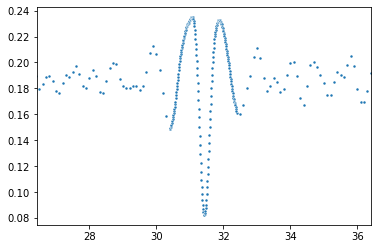

In [9]:
import numpy as np
from numba import njit


@njit(parallel=False)
def nearest_advocate_single(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                            dist_max: float, dist_padding: float, regulate_paddings: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    regulate_paddings (bool): Regulate non-overlapping events in arr_sig with a maximum distance of err_max, default True
    dist_padding (float): Distance assigned to non-overlapping (padding) events, should be 1/4 of the median gap of arr_ref. Only given if regulate_paddings is True
    '''
    # Assert input properties
    assert arr_ref.shape[0] > 0    # reference array must be non-empty
    assert arr_sig.shape[0] > 0    # signal array must be non-empty
    assert dist_max > 0.0          # maximal distance must be greater than 0.0
    if regulate_paddings:
        assert dist_padding > 0.0  # maximal distance for paddings must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
            
    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    counter = 0              # number of advocate events
    cum_distance = 0.0       # cumulative distances between advocate events
    
    # Step 1: cut leading reference timestamps without finding advocates
    while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1
        
    # return dist_max, if arr_ref ends before arr_sig starts
    if ref_idx+1 == l_arr_ref:
        return dist_max
    
    # Case: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
    assert arr_ref[ref_idx+1] > arr_sig[sig_idx]
    
    # Step 2: count leading signal timestamps with finding advocates
    while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
        # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
        if regulate_paddings:
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_padding)
            counter += 1
        sig_idx += 1
        
    # return dist_max, if arr_sig ends before arr_ref starts
    if sig_idx == l_arr_sig:
        return dist_max     
    
    # Step 3 (regular case) and step 4 (match trailing signal timestamps)
    while sig_idx < l_arr_sig:
        # Step 3: regular case
        if arr_sig[sig_idx] < arr_ref[-1]:
            # forward arr_ref and then arr_sig until regalar case
            while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx+1 >= l_arr_ref: 
                sig_idx += 1
                continue
            # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
            # assert arr_ref[ref_idx] <= arr_sig[sig_idx]
            # assert arr_sig[sig_idx] < arr_ref[ref_idx+1]
            
            cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max) 
            counter += 1
        # Step 4: match trailing reference timestamps with last signal timestamp
        elif regulate_paddings:  
            # Invariant: arr_ref[ref_idx+1] <= arr_sig[sig_idx], given by the else case
            if arr_sig[sig_idx]-arr_ref[ref_idx+1] < dist_padding:
                cum_distance += arr_sig[sig_idx]-arr_ref[ref_idx+1]
                counter += 1
            else: 
                # case with only dist_padding increments from now on
                cum_distance += (l_arr_sig - sig_idx) * dist_padding
                counter += (l_arr_sig - sig_idx)
                break # stop, because the last values can be aggregated
                
        sig_idx += 1
    
    # return mean cumulative distance between found advocate events
    return cum_distance / counter


# @njit(parallel=False)
def nearest_advocate(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                     td_min: float, td_max: float, td_prox=None, sps: float=10, sparse_factor: int=1, 
                     dist_max: float=0.0, regulate_paddings: bool=True, dist_padding: float=0.0):
    '''Calculates the synchronicity of two arrays of timestamps for a search space between td_min and td_max with a precision of 1/sps. The synchronicity is given by the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    td_min (float): lower bound of the search space for the time-shift
    td_max (float): upper bound of the search space for the time-shift
    sps (int): number of investigated time-shifts per second, should be higher than 10 times the number of median gap of arr_ref (default 10).
    sparse_factor (int): factor for the sparseness of arr_sig for the calculation, higher is faster but may be less accurate (default 1)
    dist_max (None, float): Maximal accepted distances, default None: 1/4 of the median gap of arr_ref
    dist_padding (None, float): Assumed distances of non-overlapping (padding) matches, default None: 1/4 of the median gap of arr_ref
    regulate_paddings (bool): regulate non-overlapping events in arr_sig with a maximum distance of err_max
    '''
    # set the default values for dist_max, dist_padding relative if not set
    # TODO improve default value: min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
    if dist_max <= 0.0:
        dist_max = np.median(np.diff(arr_ref))/4
    if dist_padding <= 0.0:
        dist_padding = np.median(np.diff(arr_ref))/4
    if td_prox is None:
        td_prox = 1.5 * np.median(np.diff(arr_ref))
        
    # Random subsample and create a copy of arr_sig once, as it could lead to problems otherwise
    if sparse_factor > 1:
        probe = arr_sig[sparse_factor//2::sparse_factor].copy()
    else:
        probe = arr_sig.copy()
    
    # Create an k x 2 matrix to store the investigated time-shifts and their respective mean distance
    broad_search_n_samples = int((td_max-td_min)*sps)
    fine_search_n_samples = int(2*10*td_prox*sps)   # fine search with factor 1/10 sampling
    time_delays = np.empty((broad_search_n_samples+fine_search_n_samples, 2), dtype=np.float32)
    time_delays[:broad_search_n_samples, 0] = np.arange(td_min, td_max-1e-12, 1/sps)[:broad_search_n_samples]
    # Calculate the mean distance for all time-shifts in the search space. 
    # The shift with the lowest mean distance is the best fit for the time-shift
    idx = 0
    while idx < broad_search_n_samples:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1
    
    # finesearch around the peak
    time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:broad_search_n_samples,1])]
    time_delays[broad_search_n_samples:, 0] = np.arange(time_shift-td_prox, time_shift+td_prox-1e-12, 
                                                        1/sps/10)[:fine_search_n_samples]
    # Calculate the mean distance for all time-shifts in the search space. 
    while idx < time_delays.shape[0]:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1     
    return time_delays

# run once before the test to just-in-time compile it
start_time = time.time()
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=-100, td_max=100, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

### Cross-Correlation

Found optimum at 31.400s with value 0.4921


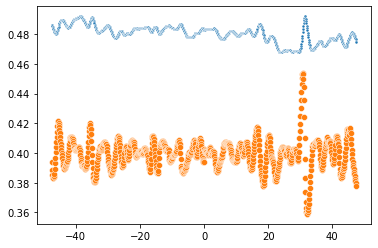

In [10]:
def pearson_cc(arr_ref: np.ndarray, arr_sig: np.ndarray, 
               mode: str="same", method: str="auto",
              smooth_outliers=False, significant_area=10):
    """Pearson Cross-correlation between two event-based time-series.
    An inter-event interpolation is performed in order to create continuous 
    signals. The results are normalized between -1 and 1
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    mode (str): mode of the scipy's cross-correlation method: 'same', 'full'
    method (str): mode of the scipy's cross-correlation method: 'auto', 'fft', 'direct'
    smooth_outliers (bool): flag if to smooth small or very high gaps after the interpolation
    significant_area (float): parameter for the extraction of the significant peak in the CC-curve, 
        Specifies the width around the largest differences for the peak detection.
    """
    # Interpolate on a constant sample rate
    stepwidth = 1/SAMPLES_PER_S
    time_vector = np.arange(int(max(arr_ref[0], arr_sig[0])), 
                            int(min(arr_ref[-1], arr_sig[-1])), 
                            step=stepwidth)
    arr_ref_cont = np.interp(time_vector, arr_ref[:-1], np.diff(arr_ref))
    arr_sig_cont = np.interp(time_vector, arr_sig[:-1], np.diff(arr_sig))
    # arr_ref_ones = np.ones(len(arr_ref_cont))
    # arr_sig_ones = np.ones(len(arr_sig_cont))
    n = len(arr_ref_cont)

    # Remove outliers
    if smooth_outliers:
        l_bound = 0.5 * np.mean(np.diff(arr_ref))
        u_bound = 2.0 * np.mean(np.diff(arr_ref))
        arr_ref_cont[arr_ref_cont < l_bound] = l_bound; arr_ref_cont[arr_ref_cont > u_bound] = u_bound; 
        arr_sig_cont[arr_sig_cont < l_bound] = l_bound; arr_sig_cont[arr_sig_cont > u_bound] = u_bound; 

    # calculte the correlation
    corrs = correlate(arr_sig_cont, arr_ref_cont, mode=mode) / np.sqrt(
        (correlate(arr_ref_cont, arr_ref_cont, mode=mode)[int(len(arr_ref_cont)/2)] 
         * correlate(arr_sig_cont, arr_sig_cont, mode=mode)[int(len(arr_sig_cont)/2)]))
    # corrs_ones = correlate(arr_sig_ones, arr_ref_ones, mode=mode, method=method)
    # corrs_ones /= corrs_ones.max()
    time_lags = stepwidth * correlation_lags(
        arr_ref_cont.size, arr_sig_cont.size, mode=mode)

    # normalize the correlations
    overlap = (stepwidth + time_lags.max() - np.abs(time_lags))/time_lags.max()
    corrs = corrs / (overlap + 1e0)
    time_delays = np.array([time_lags, corrs]).T

    if mode != "same":       
        raise Exception("Not implemented yet")
    if mode == "full":      
        # overlap above 50%    
        time_delays = time_delays[overlap > 0.5]
        
    # find the peak by searching for the largest differences in the signal
    significant_peak = np.argmax(np.diff(time_delays[:,1]))
    time_delays_proximity = time_delays[(significant_peak-significant_area*SAMPLES_PER_S//2
                                     ):significant_peak+significant_area*SAMPLES_PER_S//2]
    if len(time_delays_proximity) > 0:
        peak_idx = np.argmax(time_delays_proximity[:,1])
        time_shift, metric = time_delays_proximity[peak_idx]
    else:
        time_shift, metric = time_delays[np.argmax(time_delays[:,1])] 
    return time_shift, metric, time_delays
    
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, mode="same", method="fft")
# time_shift, metric = time_delays[np.argmax(time_delays[:,1])]
print(f"Found optimum at {time_shift:.3f}s with value {metric:.4f}")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
sns.scatterplot(x=time_delays[:-1,0], y=0.4+25*np.diff(time_delays[:,1]))
plt.show()

### Kernel Cross-Correlation

Found optimum at 31.400s with value 48.5000


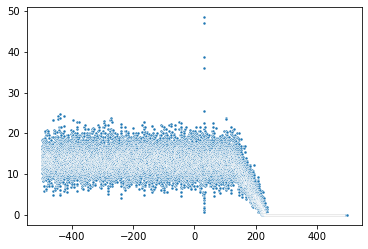

In [11]:
@numba.njit
def discretize_arrays(arr_ref, arr_sig):
    start_ts = min(arr_ref[0],arr_sig[0])
    stop_ts = max(arr_ref[-1],arr_sig[-1])
    arr_ref_onehot = np.zeros(int((stop_ts-start_ts+1)/KERNEL_PRECISION))
    arr_sig_onehot = np.zeros(int((stop_ts-start_ts+1)/KERNEL_PRECISION))
    idx = 0
    arr_ref_idx = 0
    arr_sig_idx = 0
    cum_time = start_ts - 1
    for idx in range(len(arr_ref_onehot)):
        if arr_ref_idx< len(arr_ref) and cum_time > arr_ref[arr_ref_idx]:
            arr_ref_onehot[idx] = 1
            arr_ref_idx += 1
        if arr_sig_idx< len(arr_sig) and cum_time > arr_sig[arr_sig_idx]:
            arr_sig_onehot[idx] = 1
            arr_sig_idx += 1
        cum_time += KERNEL_PRECISION
    return arr_ref_onehot, arr_sig_onehot

@numba.njit
def discretize_array(arr_ref):
    arr_ref_onehot = np.zeros(int((arr_ref[-1]-arr_ref[0]+1)/KERNEL_PRECISION))
    idx = 0
    arr_ref_idx = 0
    cum_time = 0
    for idx in range(len(arr_ref_onehot)):
        if arr_ref_idx< len(arr_ref) and cum_time > arr_ref[arr_ref_idx]:
            arr_ref_onehot[idx] = 1
            arr_ref_idx += 1
        cum_time += KERNEL_PRECISION
    return arr_ref_onehot

def kernel_cc(arr_ref: np.ndarray, arr_sig: np.ndarray,
              kernel_width: float=0.5,
               mode: str="same", method: str="auto"):
    """Kernel Cross-correlation between two event-based time-series.
    An a kernel convolution is performed in order to create continuous 
    signals. The results are normalized between -1 and 1
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    mode (str): mode of the scipy's cross-correlation method: 'same', 'full'
    method (str): mode of the scipy's cross-correlation method: 'auto', 'fft', 'direct'
    kernel_width (float): Width of the kernel for the convolution of the event-arrays.
    """
    # Discretize
    arr_ref_onehot, arr_sig_onehot = discretize_arrays(arr_ref, arr_sig)

    # Convolve with a triangular kernel of width 
    kernel = kernel_width-np.abs(np.arange(-kernel_width, kernel_width+1e-3, 2*KERNEL_PRECISION))
    # kernel = kernel / kernel.sum()
    arr_ref_cont = np.convolve(arr_ref_onehot, kernel, mode="same")
    arr_ref_cont /= arr_ref_cont.max()
    arr_sig_cont = np.convolve(arr_sig_onehot, kernel, mode="same")
    arr_sig_cont /= arr_sig_cont.max()

    # calculte the correlation
    corrs = correlate(arr_sig_cont, arr_ref_cont, mode=mode, method="fft")
    time_lags =  KERNEL_PRECISION * correlation_lags(
        arr_sig_cont.size, arr_ref_cont.size, mode=mode)

    time_delays = np.array([time_lags, corrs]).T
    time_shift, metric = time_delays[np.argmax(time_delays[:,1])]

    return time_shift, metric, time_delays

    
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_shift, metric, time_delays = kernel_cc(arr_ref, arr_sig, mode="same", method="fft", kernel_width=0.2)
print(f"Found optimum at {time_shift:.3f}s with value {metric:.4f}")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.show()

### Dynamic Linear Timewarping

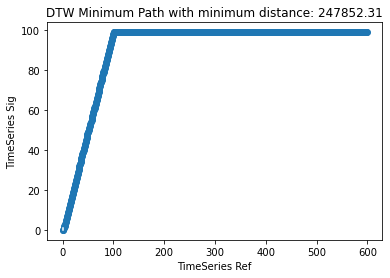

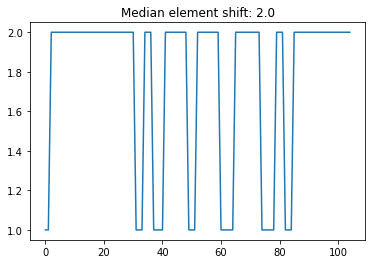

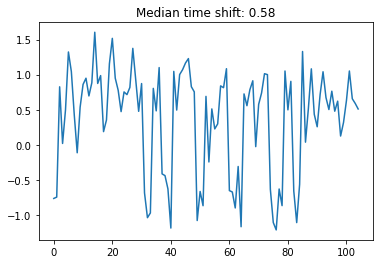

In [12]:
# TODO define other functions



# dynamic linear timewarping via recursive fastDTW implementation
# for more information see also: https://cs.fit.edu/~pkc/papers/tdm04.pdf
def dynamic_linear_timewarping(arr_ref: np.ndarray, arr_sig: np.ndarray, radius=euclidean):
    """Uses fastdtw implementation to calculate optimal alignment 
    between two time series arrays with equal length or non-equal length. 
    The warp path distance is a measure of the difference between the two time
    series after they have been warped together, which is measured by the sum 
    of the distances between each pair of points connected by the vertical lines.
    Implementation: distance, warped_path = fastDTW(x, y, radius), where:
    x = timeseries of length x
    y = timeseries of length y
    radius = search distance outside of projected warppath from previous resol. of refining warppath 
    distance = Minimum distance warppath between X and Y  
    warped_path = The warped path distance between X and Y 
    """
    
    # arr_ref_2 = np.array([arr_ref[:-1], np.diff(arr_ref)]).T
    # arr_sig_2 = np.array([arr_sig[:-1], np.diff(arr_sig)]).T
    
    # fastDTW call
    distance, warped_path = fastdtw(arr_ref, arr_sig, dist=radius) 
    
    # create dataframe_array and time_shift result
    time_shift, element_shift = [], []
    for i, (e_ref, e_sig) in enumerate(warped_path): 
        if e_ref != 0 and e_sig != 0 and e_ref < len(arr_ref)-1 and e_sig < len(arr_sig)-1:
            element_shift.append(e_ref - e_sig)
            time_shift.append(arr_ref[e_ref] - arr_sig[e_sig])
            # print(e_ref, e_sig, arr_ref[e_ref, 0], arr_sig[e_sig, 0])
            # break

    # calculate median return parameter
    median_element_shift = np.median(element_shift)
    median_time_shift = np.median(time_shift)
    
    #return all
    return distance, warped_path, element_shift, median_element_shift, time_shift, median_time_shift


# testing DTW function
arr_ref = np.cumsum(np.random.normal(loc=2, scale=0.25, size=600))
arr_sig = modify_timeseries(arr=arr_ref, offset=np.pi, sigma=0.1, fraction=0.99)[:100]
distance, warped_path, element_shift, median_element_shift, time_shift, median_time_shift = dynamic_linear_timewarping(arr_ref, arr_sig)

plt.scatter(*zip(*warped_path))
plt.plot(warped_path[0], warped_path[1], 'w')
plt.xlabel('TimeSeries Ref')
plt.ylabel('TimeSeries Sig')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(distance,2)}')
plt.show()

plt.plot(element_shift)
plt.title(f'Median element shift: {np.round(median_element_shift,2)}')
plt.show()

plt.plot(time_shift)
plt.title(f'Median time shift: {np.round(median_time_shift,2)}')
plt.show()

## Experiment 1 for HB: Precision by Length

The time-series is sampled from the real data pairs and the signal array is constrained by length

In [13]:
LENGTHS = [int(l) for l in [1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5]]
MEASUREMENTS = heart_beat_dataset  # (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    
# limit lengths to maximal length of data
min_length = np.min([min(len(pair[0]), len(pair[1])) for pair in MEASUREMENTS])
LENGTHS = [l for l in LENGTHS if l < min_length]
print(LENGTHS)

METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-FFT-smooth', 'KCC-0.5', 'KCC-1', 'DTW']  # TODO: add method specifics

MAX_TIMEOUT = 3  # maximal wait time to ignore the method afterwards
ignore_method_timeout = {k: False for k in ["PCC-FFT", 'NAd-dense']}

[10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]


In [14]:
# evaluate a given length
def evaluate_length(length):
    # parse pairs of measurements
    data_pairs = list()
    n_measurements = 0
    offset = 0
    for array_ref, array_sig in MEASUREMENTS:
        data_pairs.append((array_ref,
                           modify_timeseries(arr=array_sig, subselect_length=length)))
        data_pairs.append((array_sig,
                           modify_timeseries(arr=array_ref, subselect_length=length)))
        n_measurements += 2
    assert n_measurements == 2 * len(MEASUREMENTS)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["length"] = [length for _ in range(n_measurements)]

    # loop through all data pairs
    for idx, (arr_ref, arr_sig) in enumerate(data_pairs):
        # NAd-dense
        time_delays = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
        df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift)

        # NAd-sparse10
        time_delays = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
        df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift)

        # # NAd-sparse100
        # try:
            # time_delays = nearest_advocate(
            #     arr_ref=arr_ref, arr_sig=arr_sig, 
            #     td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
            #     dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            # time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            # df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift)
        # except AssertionError:
        #     pass
        #     # print(f"WARNING: AssertionError, skipping.")
        
        # PCC-FFT
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, mode=PCC_MODE, method="fft")
            df_precision.loc[idx, "PCC-FFT"] = np.abs(time_shift)
        except:
            pass
        
        # PCC-FFT-smooth
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, mode=PCC_MODE, method="fft", smooth_outliers=True)
            df_precision.loc[idx, "PCC-FFT-smooth"] = np.abs(time_shift)
        except:
            pass
        
        # KCC-0.5
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
            df_precision.loc[idx, "KCC-0.5"] = np.abs(time_shift)
        except:
            pass
        # KCC-1
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
            df_precision.loc[idx, "KCC-1"] = np.abs(time_shift)
        except:
            pass

        # DTW (with multiple settings?) TODO
    
    return df_precision
    
# Initialize the pool with the number of processes
with Pool(processes=30) as pool: 
    results = pool.map(evaluate_length, LENGTHS)
df_precision = pd.concat(results).sort_values("length")
df_precision.sample(5)

/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1050: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape
/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1050: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape
/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1050: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape
/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1050: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape
/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1050: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape
/opt/conda/lib/pytho

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-FFT-smooth,KCC-0.5,KCC-1,DTW,length
10,0.094000,268.614014,NaN,4.4,4.4,4736.55,9727.85,NaN,10
16,0.225000,284.464996,NaN,81.6,81.6,4.90,3509.20,NaN,200
32,0.209000,253.300003,NaN,17.4,17.4,0.20,0.25,NaN,50
1,1.957804,1.957804,NaN,9157.0,0.3,1.95,1.95,NaN,20000
5,0.028863,0.028863,NaN,548.2,548.2,0.00,0.00,NaN,1000


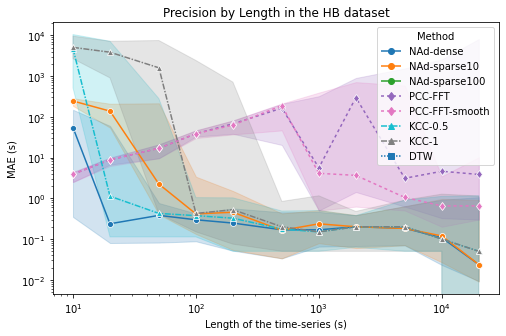

In [15]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="precision")

precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="length", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Precision by Length in the HB dataset")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.savefig("fig/realpairs_precision_length_HB.png")
plt.show()